In [ ]:
#Домашнее задание по теме «Рекомендации на основе содержания»
#Преподаватель: Александр Кондрашкин
#
#    1. Использовать dataset MovieLens
#    2. Построить рекомендации (регрессия, предсказываем оценку) на фичах:
#
#    3. TF-IDF на тегах и жанрах
#    4. Средние оценки (+ median, variance, etc.) пользователя и фильма
#
#    5. Оценить RMSE на тестовой выборке



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Фичи будут складываться из tf-idf на жанрах и тегах,  

In [7]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [10]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [11]:
def change_string(l):
    return '|'.join(l).replace(' ', '').replace('-', '')

In [18]:
# для построение векторов на базе tfidf соберем теги

tags_gr = pd.DataFrame(tags.groupby('movieId').apply(lambda x: change_string(list(x['tag']))), columns=['tags']).reset_index()

In [84]:
# соберем данные по тегам и жанрам в одну таблицу
# добавим год производства фильма  

import re

movie_tag_gnr = pd.merge(movies, tags_gr, on='movieId', how='left' ).fillna('')
movie_tag_gnr['tags_gnr'] = movie_tag_gnr.apply(lambda x: x['genres']+ ('|'+str(x['tags'])  if str(x['tags']) != '' else ''), axis=1)
movie_tag_gnr['year'] = movie_tag_gnr.apply(lambda x: int(re.findall(r'(?<=\()\d{2,4}(?=\))', str(x['title']))[-1]) if len(re.findall(r'\(\d{2,4}\)', str(x['title']))) > 0 else 0 , axis=1)
movie_tag_gnr.head()

,movieId,title,genres,tags,tags_gnr,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar|pixar|fun,Adventure|Animation|Children|Comedy|Fantasy|pi...,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy|magicboardgame|RobinWilliams|game,Adventure|Children|Fantasy|fantasy|magicboardg...,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy|old,Comedy|Romance|moldy|old,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,pregnancy|remake,Comedy|pregnancy|remake,1995


In [55]:
# Для генерацити фич испорльзуем следующие моменты
# из тегов
# -- средняя длина тега
# -- количество тегов (с повторами)
# -- для учета параметров времени выставления тегов
# -- среднее время между тегами
# -- время прошедшее с первого выставления тага
# -- время прошедшее с последнего выставления тага
#
# -- количестиво пользователей поставивших тег 
# -- среднее количество выставления тегов на пользователя
#
# из жанров
# -- количество жанров
# 
# -- год производства 

# DataFrame для сбора фич
result = pd.DataFrame(movies['movieId'])
result.shape

(9742, 1)

In [56]:
# -- длинна тега и средняя длина тега
tags['len_tag'] = tags.apply(lambda x: len(x['tag'].split(' ')), axis=1)
result['mean_len_tag'] = tags[['len_tag','movieId']].groupby('movieId').mean()

In [57]:
# -- количество тегов (с повторами)
result['count_tag'] = tags[['tag','movieId']].groupby('movieId').count()
result.fillna(0, inplace=True)
result.head()

,movieId,mean_len_tag,count_tag
0,1,0.00,0.0
1,2,1.00,3.0
2,3,1.75,4.0
3,4,1.00,2.0
4,5,0.00,0.0


In [213]:
import time

curent_time = time.time()


# -- среднее время прошедшее между выставлением тегов
result['avg_time'] = tags.sort_values(['movieId','timestamp']).groupby('movieId').apply(lambda x: (x['timestamp'].iloc[1:]-x['timestamp'].iloc[:-1]).mean() if len(x['timestamp']) > 1 else 0 )
result.fillna(0, inplace=True)


# -- время прошедшее с поставки первого тега
result['first_time'] = curent_time - tags[['movieId','timestamp']].groupby('movieId').min()
# -- время прошедшее с поставки последнего тега
result['last_time'] = curent_time - tags[['movieId','timestamp']].groupby('movieId').max()
result.fillna(0, inplace=True)
result.head(10)

,movieId,mean_len_tag,count_tag,avg_time,first_time,last_time,count_user,count_genres
0,1,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5
1,2,1.00,3.0,0.0,4.182849e+08,3.020567e+07,3.0,3
2,3,1.75,4.0,0.0,4.181161e+08,2.664775e+07,4.0,2
3,4,1.00,2.0,0.0,4.120668e+08,4.120668e+08,2.0,3
4,5,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,1
5,6,1.00,2.0,0.0,4.181178e+08,4.181178e+08,2.0,3
6,7,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,2
7,8,1.00,1.0,0.0,4.181160e+08,4.181160e+08,1.0,2
8,9,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,1
9,10,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,3


In [59]:
# -- количество user'ов уставивших тег
result['count_user'] = tags[['movieId','userId']].groupby('movieId').count()
result.fillna(0, inplace=True)
result.head()

,movieId,mean_len_tag,count_tag,avg_time,first_time,last_time,count_user
0,1,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0
1,2,1.00,3.0,0.0,4.182746e+08,3.019542e+07,3.0
2,3,1.75,4.0,0.0,4.181059e+08,2.663750e+07,4.0
3,4,1.00,2.0,0.0,4.120566e+08,4.120566e+08,2.0
4,5,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0


In [60]:
# -- количество жанров
result['count_genres'] = movies['genres'].apply(lambda x: len(x.split('|')))
result.head()

,movieId,mean_len_tag,count_tag,avg_time,first_time,last_time,count_user,count_genres
0,1,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5
1,2,1.00,3.0,0.0,4.182746e+08,3.019542e+07,3.0,3
2,3,1.75,4.0,0.0,4.181059e+08,2.663750e+07,4.0,2
3,4,1.00,2.0,0.0,4.120566e+08,4.120566e+08,2.0,3
4,5,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,1


In [90]:
# добавим в результирующую таблицу информация о тегах и жанрах
result_text = pd.merge(result, movie_tag_gnr[['movieId','tags_gnr','year']], on='movieId', how='left')
result_text.head()

,movieId,mean_len_tag,count_tag,avg_time,first_time,last_time,count_user,count_genres,tags_gnr,year
0,1,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5,Adventure|Animation|Children|Comedy|Fantasy|pi...,1995
1,2,1.00,3.0,0.0,4.182746e+08,3.019542e+07,3.0,3,Adventure|Children|Fantasy|fantasy|magicboardg...,1995
2,3,1.75,4.0,0.0,4.181059e+08,2.663750e+07,4.0,2,Comedy|Romance|moldy|old,1995
3,4,1.00,2.0,0.0,4.120566e+08,4.120566e+08,2.0,3,Comedy|Drama|Romance,1995
4,5,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,1,Comedy|pregnancy|remake,1995


In [91]:
# получим целевые значения
y_ratings = pd.merge(movies, ratings, on='movieId', how='left' )[['movieId','rating']].groupby('movieId').agg({'rating':['mean','std'] }).reset_index()
y_ratings.head()

movieId    rating          
               mean       std
0       1  3.920930  0.834859
1       2  3.431818  0.881713
2       3  3.259615  1.054823
3       4  2.357143  0.852168
4       5  3.071429  0.907148

In [92]:
result_text_rating = pd.merge(result_text, y_ratings, on='movieId', how='left') 
result_text_rating.head()

/home/lvm/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/lvm/.local/lib/python3.6/site-packages/pandas/core/generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,movieId,mean_len_tag,count_tag,avg_time,first_time,last_time,count_user,count_genres,tags_gnr,year,"(rating, mean)","(rating, std)"
0,1,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5,Adventure|Animation|Children|Comedy|Fantasy|pi...,1995,3.920930,0.834859
1,2,1.00,3.0,0.0,4.182746e+08,3.019542e+07,3.0,3,Adventure|Children|Fantasy|fantasy|magicboardg...,1995,3.431818,0.881713
2,3,1.75,4.0,0.0,4.181059e+08,2.663750e+07,4.0,2,Comedy|Romance|moldy|old,1995,3.259615,1.054823
3,4,1.00,2.0,0.0,4.120566e+08,4.120566e+08,2.0,3,Comedy|Drama|Romance,1995,2.357143,0.852168
4,5,0.00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,1,Comedy|pregnancy|remake,1995,3.071429,0.907148


In [112]:
# удалим фильмы без рейтинга
print(result_text_rating.shape)
result_text_rating.dropna(inplace=True)
result_text_rating.shape


(6278, 12)


(6278, 12)

In [149]:
# построим матрицу корреляции

corr = result_text_rating.corr()

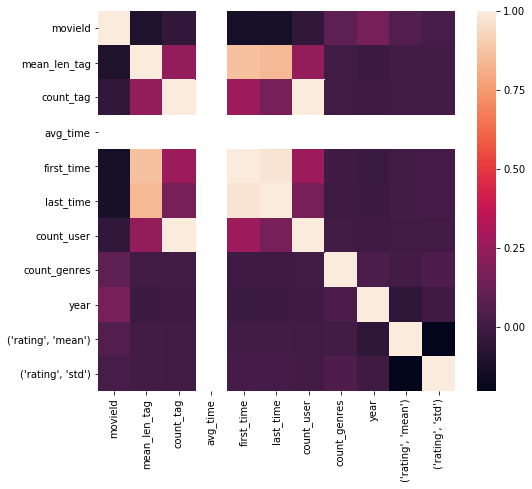

In [152]:
plt.figure(figsize=(8, 7))
sns.heatmap(corr)

In [ ]:
# посмотрим зависимости между параметрами

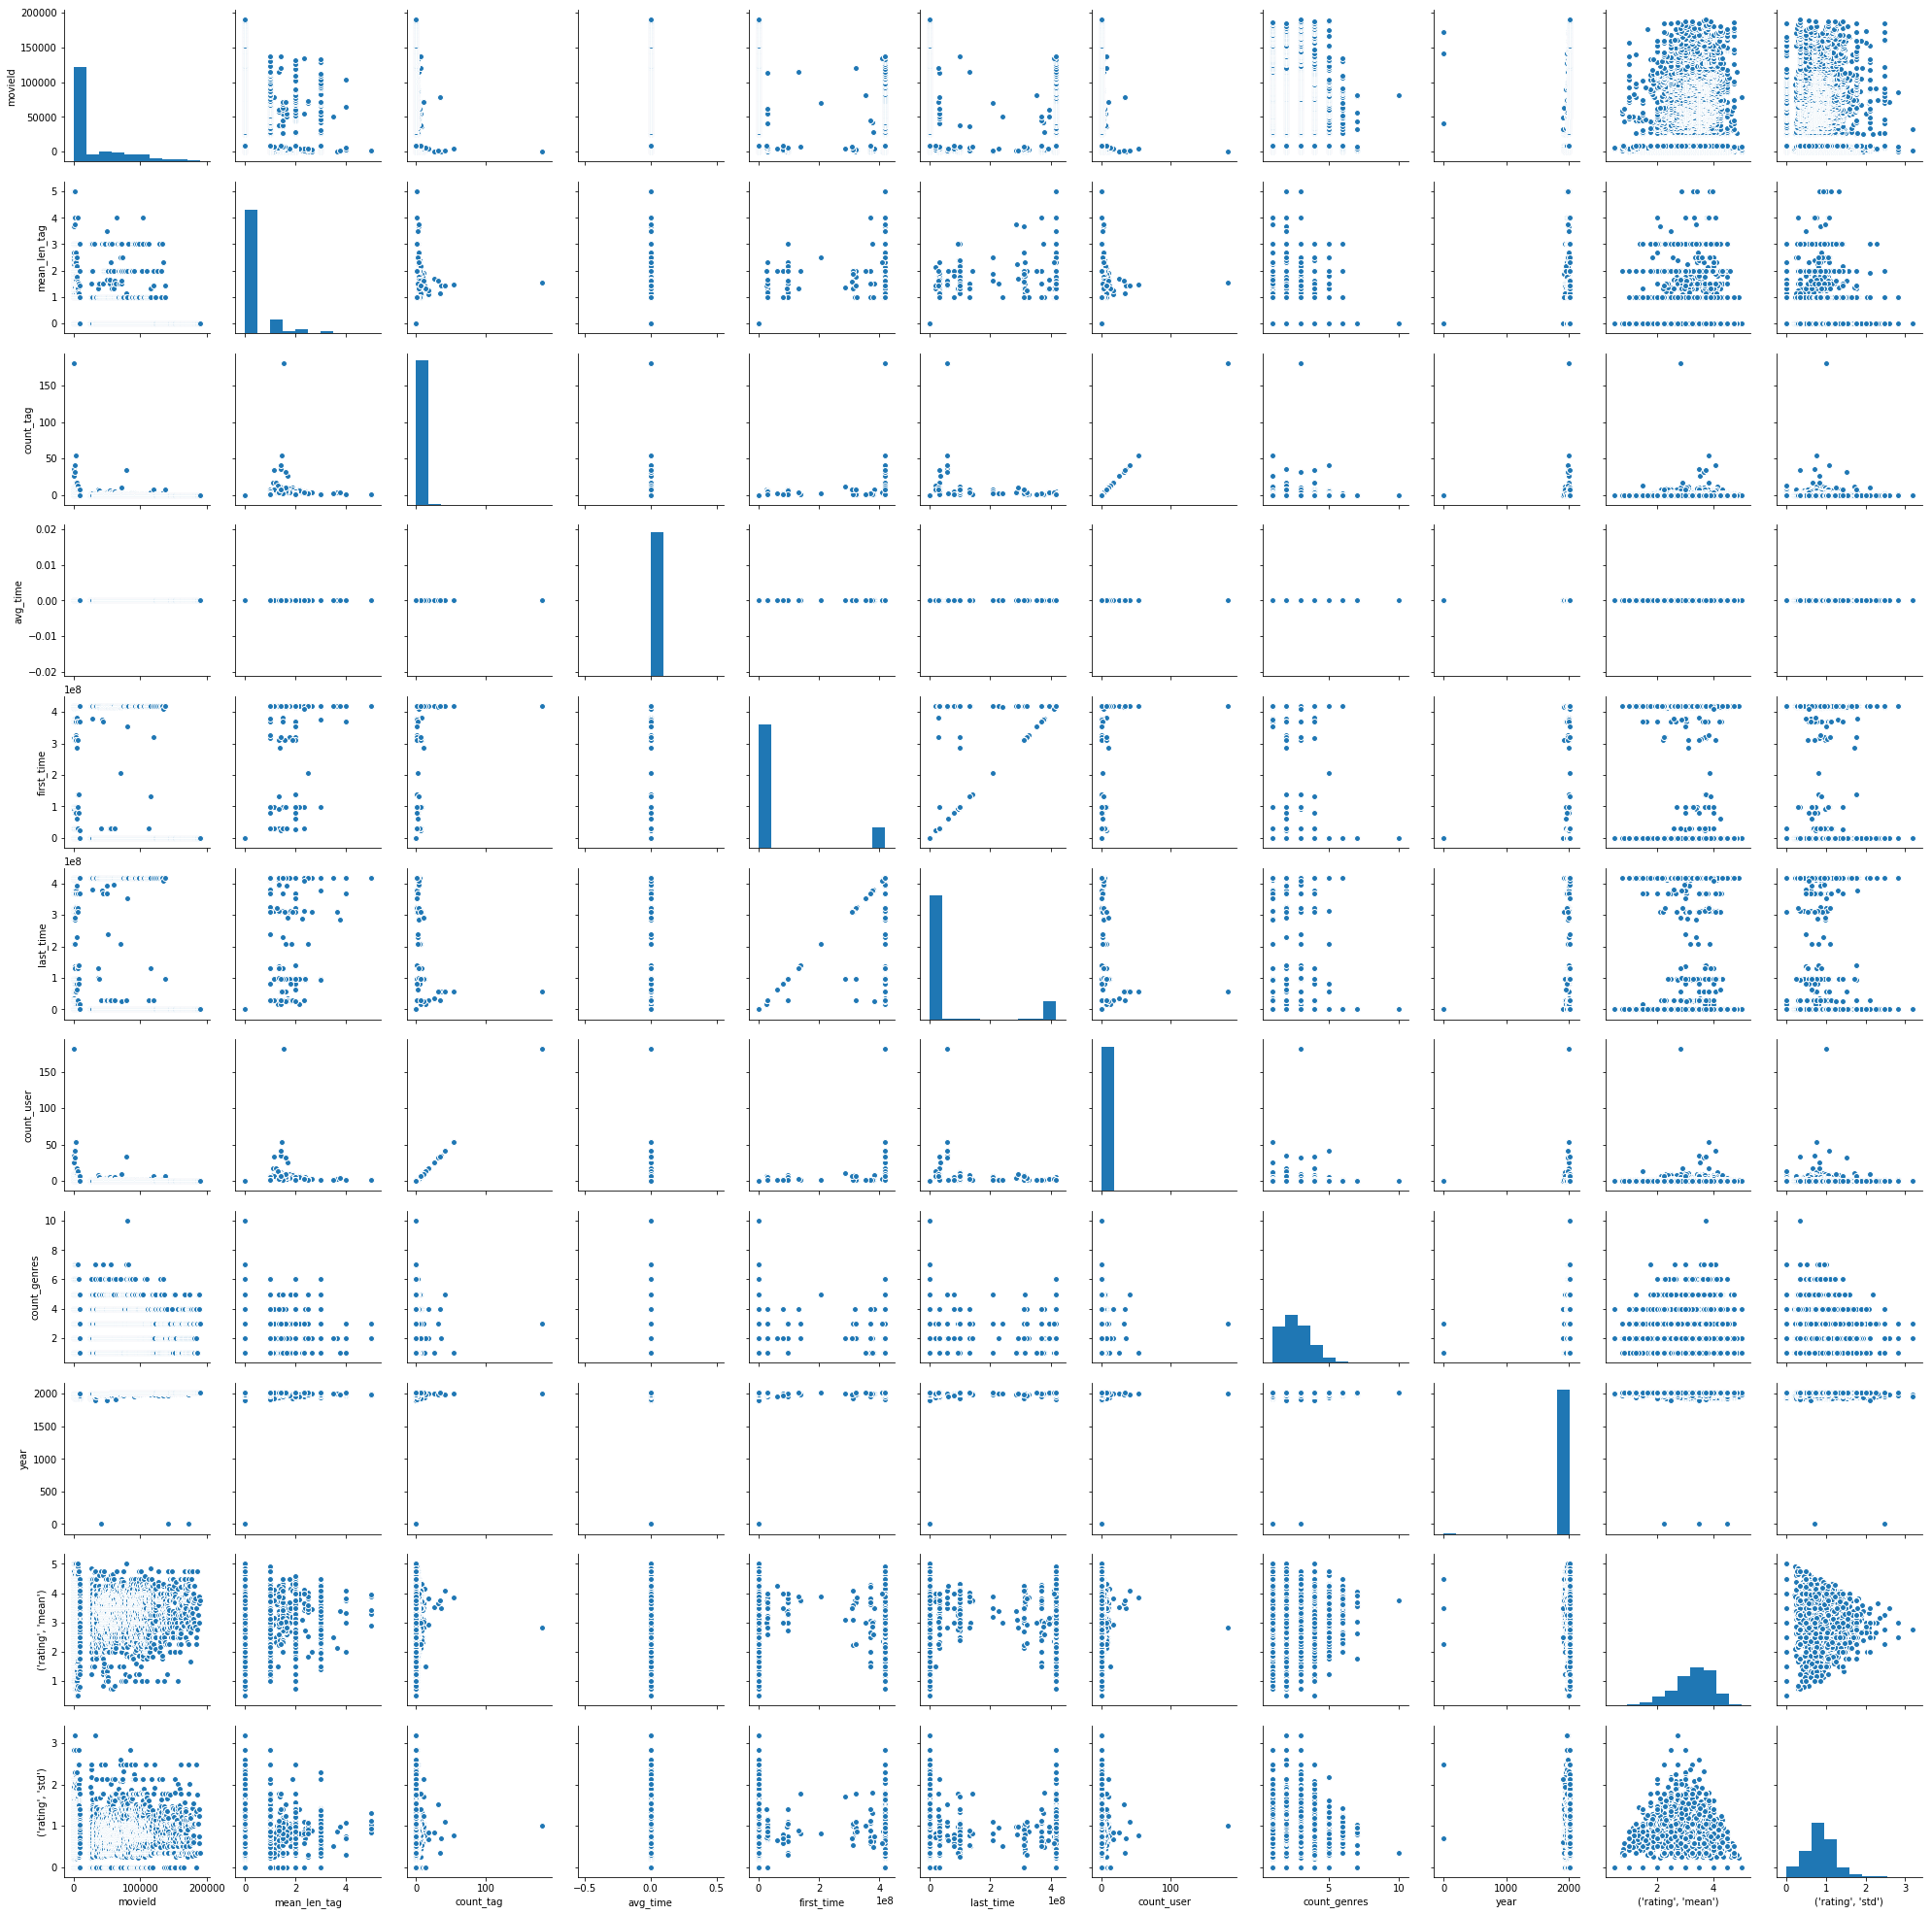

In [148]:
import seaborn as sns

sns.pairplot(result_text_rating)

In [ ]:
# Как видно хороших зависимостей не графиках для целевых значений невидно

In [107]:
# мы получили данные
# теперь получим тестовую и обучающкю выборки
y_all = result_text_rating[[('rating', 'mean'),('rating', 'std')]]
X_all = result_text_rating.drop(columns=[('rating', 'mean'),('rating', 'std')], axis=1)
y_all.head()

,"(rating, mean)","(rating, std)"
0,3.920930,0.834859
1,3.431818,0.881713
2,3.259615,1.054823
3,2.357143,0.852168
4,3.071429,0.907148


In [178]:
# Разделим выборку на тестовую и обучающую

X_train,  X_test,y_train, y_test = train_test_split(X_all,y_all[[('rating','mean'),('rating','std')]], test_size=0.3 )

In [220]:
# обучим tf_idf векорайзер и получим представление для обучающей выборки

tfidf_transformer = TfidfVectorizer(ngram_range=(1,3))
X_train_tfidf = tfidf_transformer.fit_transform(X_train['tags_gnr'])

# получим tf_idf для тестовой выборки
X_test_tfidf = tfidf_transformer.transform(X_test['tags_gnr'])


In [221]:
# удалим текстовые столбцы из выборок
X_tr = X_train.drop(columns=['tags_gnr'])
X_ts = X_test.drop(columns=['tags_gnr'])

In [222]:
# отмасштабируем значения выборок
from sklearn.preprocessing import StandardScaler

# для обучающей выборки
sc = StandardScaler()
X_tr_sc = sc.fit_transform(X_tr)

# для тестовой выборки
X_ts_sc = sc.transform(X_ts)


In [223]:

from scipy.sparse import hstack

# добавим к полученным tf_idf представлениям полученные фичи 

X = hstack((X_train_tfidf,np.array(X_tr_sc)))
X_t = hstack((X_test_tfidf ,np.array(X_ts_sc)))

In [224]:
# выберем модели

In [225]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [226]:
# подготовим параметры для подбора гиперпараметров
param_model_GS = {'Ridge':{'alpha':[0.1,0.5,1]}, 
              'Lasso':{'alpha':[0.1,0.5,1]}, 
              'KNeighborsRegressor':{'n_neighbors':[3,5,7,9]},
              'LinearSVR':{'C':[0.1,0.5,1], 'loss':['epsilon_insensitive', 'squared_epsilon_insensitive']},
              'DecisionTreeRegressor':{'max_depth':[3,5,7,9]},                                    
              'LinearRegression':{},
              'RandomForestRegressor': {'max_depth':[3,5,7,9]},
              'GradientBoostingRegressor':{'loss' : ['ls', 'lad', 'huber', 'quantile']}   
             }

y = y_train[('rating','mean')]

# Обучим модели

Rg  = GridSearchCV(Ridge(), param_model_GS['Ridge'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
Ls  = GridSearchCV(Lasso(), param_model_GS['Lasso'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
KNR = GridSearchCV(KNeighborsRegressor(), param_model_GS['KNeighborsRegressor'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
SVR = GridSearchCV(LinearSVR(), param_model_GS['LinearSVR'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
DTR = GridSearchCV(DecisionTreeRegressor(), param_model_GS['DecisionTreeRegressor'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
LR  = LinearRegression().fit(X,y).predict(X_t)
RFR = GridSearchCV(RandomForestRegressor(), param_model_GS['RandomForestRegressor'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
GBR = GridSearchCV(GradientBoostingRegressor(), param_model_GS['GradientBoostingRegressor'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)


In [240]:
# для сравнения сделаем искуственное предсказание со средним значением
avg_rating = Rg.copy()
avg_rating[:] = y_train[('rating','mean')].mean()
y_t = y_test[('rating','mean')]

In [243]:
print('avg_rating: {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,avg_rating), mean_absolute_error(y_t,avg_rating),r2_score(y_t,avg_rating) ))
print('ridge     : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,Rg), mean_absolute_error(y_t,Rg),r2_score(y_t,Rg)))
print('lasso     : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,Ls),mean_absolute_error(y_t,Ls),r2_score(y_t,Ls)))
print('KNR       : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,KNR),mean_absolute_error(y_t,KNR),r2_score(y_t,KNR)))
print('SVR       : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,SVR),mean_absolute_error(y_t,SVR),r2_score(y_t,SVR)))
print('DTR       : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,DTR),mean_absolute_error(y_t,DTR),r2_score(y_t,DTR)))
print('LR        : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,LR),mean_absolute_error(y_t,LR),r2_score(y_t,LR)))
print('RFR       : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,RFR), mean_absolute_error(y_t,RFR),r2_score(y_t,RFR)))
print('GBR       : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,GBR),mean_absolute_error(y_t,GBR),r2_score(y_t,GBR)))

avg_rating: 0.47 (abs:0.55, R2:-0.00)
ridge     : 0.37 (abs:0.48, R2:0.20)
lasso     : 0.47 (abs:0.55, R2:-0.00)
KNR       : 0.42 (abs:0.51, R2:0.11)
SVR       : 0.37 (abs:0.48, R2:0.21)
DTR       : 0.37 (abs:0.47, R2:0.21)
LR        : 0.41 (abs:0.50, R2:0.12)
RFR       : 0.36 (abs:0.46, R2:0.24)
GBR       : 0.35 (abs:0.46, R2:0.26)


In [251]:
# Как видно из полученных результатов
# наши модели предсказывают чуть лучше, чем предсказание средним

# интересен результат от модели Lasso. Судя по результату модель зарегулировала модель до прямой

est_l = GridSearchCV(Lasso(), param_model_GS['Lasso'], cv=5, n_jobs=-1).fit(X,y).best_estimator_


In [253]:
print(f'{est_l.coef_} , sum:{sum(est_l.coef_)}')
print(est_l.intercept_ )

[ 0.  0.  0. ...  0. -0. -0.] , sum:0.0
3.2784164380666194


In [ ]:
# Предположение подтвердилось  L1-регуряризация убрала все коэффициенты в 0 оставив только смещение 

In [247]:
#  самая успешная модель Градиентный бустинг
y = y_train[('rating','mean')]

est = GridSearchCV(GradientBoostingRegressor(), param_model_GS['GradientBoostingRegressor'], cv=5, n_jobs=-1).fit(X,y).best_estimator_


In [260]:
print(np.sum(np.floor(np.array(est.feature_importances_)+0.99999999)))
X.shape

141.0


(4394, 5910)

In [261]:
# из 5910 фич модель использует только 141

In [230]:
# посмотрим как модели предсказывают стандартное отклонение
y = y_train[('rating','std')]

Rg_std  = GridSearchCV(Ridge(), param_model_GS['Ridge'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
Ls_std  = GridSearchCV(Lasso(), param_model_GS['Lasso'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
KNR_std = GridSearchCV(KNeighborsRegressor(), param_model_GS['KNeighborsRegressor'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
SVR_std = GridSearchCV(LinearSVR(), param_model_GS['LinearSVR'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
DTR_std = GridSearchCV(DecisionTreeRegressor(), param_model_GS['DecisionTreeRegressor'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
LR_std  = LinearRegression().fit(X,y).predict(X_t)
RFR_std = GridSearchCV(RandomForestRegressor(), param_model_GS['RandomForestRegressor'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)
GBR_std = GridSearchCV(GradientBoostingRegressor(), param_model_GS['GradientBoostingRegressor'], cv=5, n_jobs=-1).fit(X,y).best_estimator_.predict(X_t)


In [244]:
avg_std = Rg_std.copy()
avg_std[:] = y_train[('rating','std')].mean()
y_t = y_test[('rating','std')]

In [245]:
print('avg_std   : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,avg_std), mean_absolute_error(y_t,avg_std),r2_score(y_t,avg_std) ))
print('ridge     : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,Rg_std), mean_absolute_error(y_t,Rg_std),r2_score(y_t,Rg_std)))
print('lasso     : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,Ls_std),mean_absolute_error(y_t,Ls_std),r2_score(y_t,Ls_std)))
print('KNR       : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,KNR_std),mean_absolute_error(y_t,KNR_std),r2_score(y_t,KNR_std)))
print('SVR       : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,SVR_std),mean_absolute_error(y_t,SVR_std),r2_score(y_t,SVR_std)))
print('DTR       : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,DTR_std),mean_absolute_error(y_t,DTR_std),r2_score(y_t,DTR_std)))
print('LR        : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,LR_std),mean_absolute_error(y_t,LR_std),r2_score(y_t,LR_std)))
print('RFR       : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,RFR_std), mean_absolute_error(y_t,RFR_std),r2_score(y_t,RFR_std)))
print('GBR       : {:.2f} (abs:{:.2f}, R2:{:.2f})'.format(mean_squared_error(y_t,GBR_std),mean_absolute_error(y_t,GBR_std),r2_score(y_t,GBR_std)))


avg_std   : 0.15 (abs:0.29, R2:-0.00)
ridge     : 0.15 (abs:0.29, R2:0.00)
lasso     : 0.15 (abs:0.29, R2:-0.00)
KNR       : 0.16 (abs:0.30, R2:-0.06)
SVR       : 0.15 (abs:0.29, R2:0.01)
DTR       : 0.15 (abs:0.29, R2:0.01)
LR        : 0.18 (abs:0.31, R2:-0.14)
RFR       : 0.15 (abs:0.29, R2:0.01)
GBR       : 0.15 (abs:0.28, R2:0.04)


In [232]:
# Как видно из полученных результатов
# наши модели предсказывают так же как предсказание средним :)